# Kampff lab - Polytrode Impedance


Here a description of the dataset:
http://www.kampff-lab.org/polytrode-impedance

Here the official publication of this open dataset:
https://crcns.org/data-sets/methods/evi-1/about-evi-1

And the citation:
Joana P Neto, Pedro Baião, Gonçalo Lopes, João Frazão, Joana Nogueira, Elvira Fortunato, Pedro Barquinha, Adam R Kampff (2018); Extracellular recordings using a dense electrode array allowing direct comparison of the same neural signal measured with low and high impedance electrodes CRCNS.org
http://dx.doi.org/10.6080/K07M064M

And a paper on results in Frontier
https://doi.org/10.3389/fnins.2018.00715

## Introduction


For this study they use polytrode aranged in chess board so that 16 of electrodes have a 1Mohm (at 1kHz) impedance and other 16 have 100kohm impedance.

The goal of this is notebook is to reproduce the spike sorting pipeline on the dataset.
In the official paper in frontier, Joana Neto and co, use kilosort for spike sorting but no public report the result of the dataset.

Here is a replicate and reproducible pipeline with tridesclous.

This is done only on one file **amplifier2017-02-02T17_18_46** but the same script can be applied easly on other files form teh same dataset.

## Download

Dataset must downloaded locally and manually from crcns or from the google drive in **"workdir"** path.



## The PRB file
tridesclous need a PRB file that describe the geometry of probe.

Create it by copy/paste or download it via github.

Here I split the probe in 2 groups : 
  * **0** is 1Mohm electrodes
  * **1** is 100kohm electrodes

```python
channel_groups = {
    0: {
        'channels':  [0, 24, 1, 10, 25, 15, 11, 26, 14, 12, 27, 8, 13, 28, 9, 2],
        'graph' : [],
        'geometry': {
            0: [18.0, 0.0],
            24: [0.0, 37.5],
            1: [18.0, 50.],
            10: [36., 62.5],
            25: [0.0, 87.5],
            15: [18.0, 100.0],
            11: [36.0, 112.5],
            26: [0.0, 137.5],
            14: [18.0, 150.0],
            12: [36.0, 162.5],
            27: [0.0, 187.5],
            8: [18.0, 200.0],
            13: [36.0, 212.5],
            28: [0.0, 237.5],
            9: [18.0, 250.0],
            2: [36.0, 262.5]
        }
    },
    1: {
        'channels':  [31, 7, 21, 30, 6, 20, 16, 5, 19, 17, 4, 18, 23, 3, 29, 22],
        'graph' : [],
        'geometry': {
            31: [18.0, 12.5],
            7: [36.0, 37.5],
            21: [0.0, 62.5],
            30: [18.0, 75.0],
            6: [36.0, 87.5],
            20: [0.0, 112.5],
            16: [18.0, 125.0],
            5: [36.0, 137.5],
            19: [0.0, 162.5],
            17: [18.0, 175.0],
            4: [36.0, 187.5],
            18: [0.0, 212.5],
            23: [18.0, 225.0],
            3: [36.0, 237.5],
            29: [0.0, 262.5],
            22: [18.0, 275.0]
        }
    }
}
```

In [1]:
# suposing the datset is downloaded here
workdir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/polytrode Impedance/'
filename = workdir + 'amplifier2017-02-02T17_18_46/amplifier2017-02-02T17_18_46.bin'


In [2]:
#%matplotlib inline
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt
import tridesclous as tdc
from tridesclous import DataIO, CatalogueConstructor, Peeler
import os, shutil

## create a DataIO (and remove if already exists)

In [3]:
dirname = workdir + 'tdc_amplifier2017-02-02T17_18_46'

if os.path.exists(dirname):
    #remove is already exists
    shutil.rmtree(dirname)
    
dataio = DataIO(dirname=dirname)

# feed DataIO with one file
dataio.set_data_source(type='RawData', filenames=[filename], sample_rate=20000., dtype='uint16', total_channel=32)
print(dataio)

# set the probe file
dataio.set_probe_file('kampff_polytrode_impedance_32.prb')

DataIO <id: 140410429838168> 
  workdir: /media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/polytrode Impedance/tdc_amplifier2017-02-02T17_18_46
  sample_rate: 20000.0
  total_channel: 32
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch28 ch29 ch30 ch31]
  nb_segment: 1
  length: 6958592
  durations: 347.9 s.


## CatalogueConstructor

In [ ]:
cc = CatalogueConstructor(dataio=dataio, chan_grp=0)

cc.set_preprocessor_params(chunksize=1024, common_ref_removal=False,
            highpass_freq=250., lowpass_freq=9500.,                                             
            peak_sign='-', relative_threshold=5., peak_span=0.0001)

cc.estimate_signals_noise(duration=30.)
cc.run_signalprocessor(duration=500.)
cc.extract_some_waveforms(n_left=-15, n_right=20, mode='rand', nb_max=10000)
cc.clean_waveforms(alien_value_threshold=100.)
cc.extract_some_features(method='peak_max')
cc.find_clusters(method='sawchaincut')

print(cc)


(40, 240)

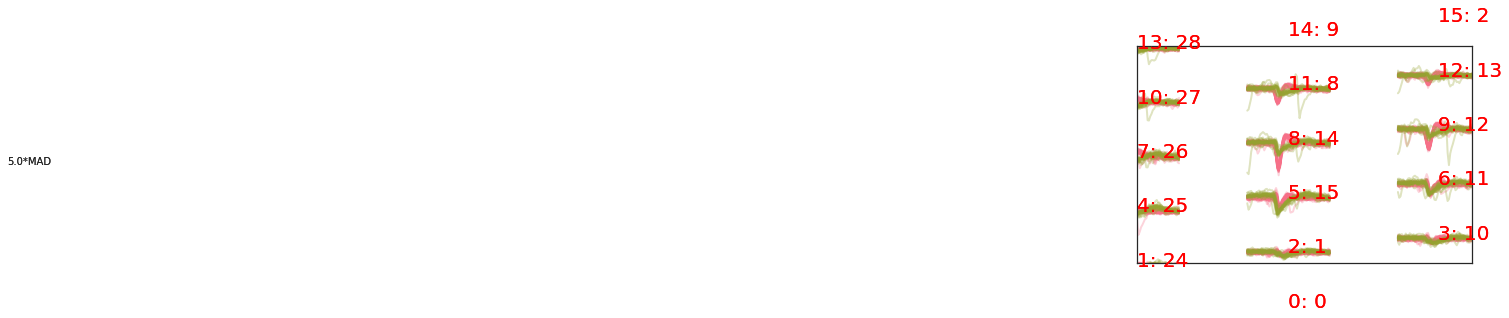

In [40]:
fig, ax = plt.subplots()
tdc.plot_waveforms(cc, labels=[0,], ratioY=1,deltaX=5, ax=ax, show_amplitude=True)
ax.set_xlim(0,40)
ax.set_ylim(40, 240)

In [37]:
# TODO histwaveforms
# plot_waveforms witj microvolts
# plot_waveform_withcentroid
# print_summary_cluster
# plt_summary_cluster




## construct catalogue

In [42]:
cc.make_catalogue_for_peeler()

make_catalogue 0.08496177399865701


## apply peeler

In [44]:
initial_catalogue = dataio.load_catalogue(chan_grp=0)
peeler = Peeler(dataio)
peeler.change_params(catalogue=initial_catalogue)
peeler.run(duration=None, progressbar=True)



100%|██████████| 6795/6795 [00:25<00:00, 266.57it/s]
